In [4]:
import os
import sys
import warnings
import pandas as pd
from tqdm.notebook import tqdm
import pickle
from socceraction.data.statsbomb import StatsBombLoader
from statsbombpy import sb

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)
from express.databases import SQLiteDatabase
from express.visualization import plot_action
from express.utils import add_names
from functools import partial

from express.datasets import PressingDataset
from tqdm import tqdm
import pandas as pd
from pathlib import Path

import shap
import matplotlib.pyplot as plt


base_path: c:\Users\mirun\24_winter\press\sr-press


In [5]:
model = "xgboost" #"soccermap"
trial = 13 # as you like

path = Path(base_path) / "stores" / "model" / model / f"{trial:03d}" / "component.pkl"
with path.open(mode="rb") as file:
    component = pickle.load(file)
component

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")
test_db = SQLiteDatabase(TEST_DB_PATH)
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "filtered_datasets", "test"))


### SHAP 시각화하기

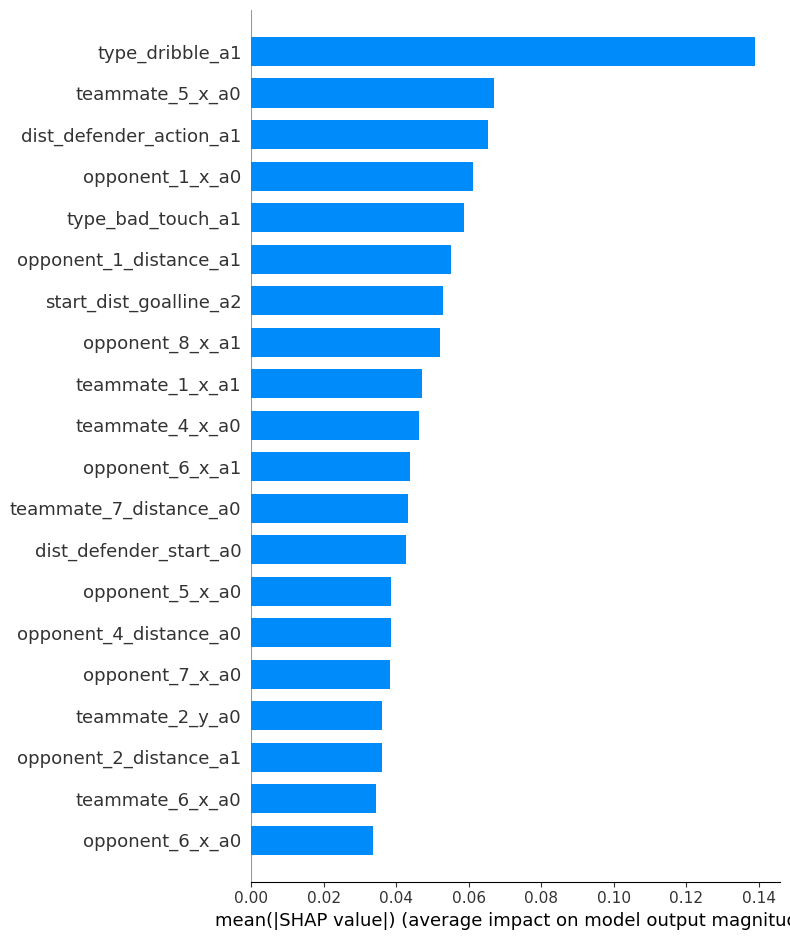

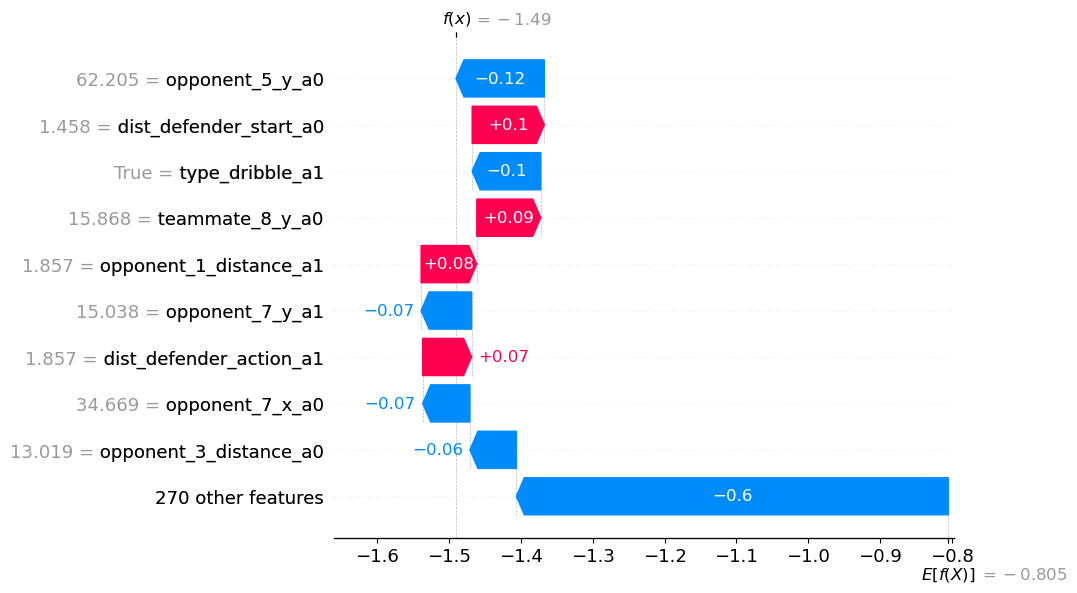

In [7]:
data = component.initialize_dataset(dataset_test)
X_test = data.features
y_test = data.labels


# XGBoost 모델 가져오기
model = component.model

# SHAP Explainer 생성 (XGBoost 모델의 경우 TreeExplainer 사용)
explainer = shap.TreeExplainer(model)

# 테스트 데이터셋에 대해 SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# SHAP 값 시각화
# (1) summary_plot: 전체 피처의 중요도와 영향력을 시각화
shap.summary_plot(shap_values, X_test, plot_type="bar")

# (2) 특정 데이터 포인트에 대한 waterfall_plot 생성
shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=X_test.iloc[0,:]))

plt.show()


### Team_id를 team_name으로 매핑하기

In [8]:
teams_data = []
seen_team_ids = set()
for idx, game in tqdm(test_db.games().iterrows(), total=len(test_db.games())):
    game_id = idx
    
    # game_id에 해당하는 팀 정보를 가져오기
    teams = SBL.teams(game_id)  
    
    # 각 팀에 대해 고유한 팀 정보를 추출
    for i in range(len(teams)):
        team_id = teams.iloc[i]['team_id']
        team_name = teams.iloc[i]['team_name']
        
        # 중복된 team_id는 추가하지 않음
        if team_id not in seen_team_ids:
            teams_data.append({
                'team_id': team_id,
                'team_name': team_name
            })
            seen_team_ids.add(team_id)  # 추적 집합에 추가하여 중복을 방지

teams_df = pd.DataFrame(teams_data)


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:32<00:00,  1.99it/s]


30초 정도 걸리지만 teams_2_id.json 파일을 쓰셔도 됩니다.

In [52]:
import json
team_mapping_dict = teams_df.set_index('team_id')['team_name'].to_dict()

# JSON 파일로 저장
with open('teams_2_id.json', 'w') as file:
    json.dump(team_mapping_dict, file)

### Preds값 가져오기

In [9]:

preds = component.predict(dataset_test)
preds

game_id  action_id
3857254  4            0.183938
         14           0.090456
         17           0.107374
         22           0.163946
         34           0.144515
                        ...   
3869685  3013         0.116331
         3020         0.486524
         3031         0.428883
         3041         0.231317
         3045         0.404881
Length: 14504, dtype: float32

In [16]:
test_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "filtered_datasets", "test"),
    xfns=["closest_11_players", "actiontype_onehot", "get_average_column_sum_to_player","dist_opponent","relative_startlocation"],
    yfns=["posession_change"],
    load_cached=True,
    nb_prev_actions=3
)

In [18]:
new=test_dataset.labels.copy()
new['posession_change_prob'] = preds.values
new


posession_change  posession_change_prob
game_id action_id                                         
3857254 4                     False               0.183938
        14                    False               0.090456
        17                    False               0.107374
        22                    False               0.163946
        34                    False               0.144515
...                             ...                    ...
3869685 3013                  False               0.116331
        3020                  False               0.486524
        3031                  False               0.428883
        3041                  False               0.231317
        3045                  False               0.404881

[14504 rows x 2 columns]

### pressing action마다 team_id 찾아서 append하기
- 이것보다 빠르게 구할 수 있는 방법 아신다면 수정해주십시오...
- 50분정도 걸립니다

In [ ]:
from tqdm import tqdm
teams_id = []  # 딕셔너리가 아닌 리스트로 초기화합니다.

# 데이터프레임을 순회하며 각 (game_id, action_id)에 대해 팀 ID를 찾습니다.
for (game_id, action_id), row in tqdm(new.iterrows(), total=len(new)):
   
    # add_names()를 사용하여 특정 game_id에 대한 액션을 가져옵니다.
    actions = add_names(test_db.actions(game_id))

    # 해당 game_id와 action_id를 사용하여 필요한 인덱스의 값을 가져옵니다.
    idx = (game_id, action_id)

    try:
        # 인덱스가 존재할 경우 team_id를 teams_id 리스트에 추가합니다.
        team_id = actions.loc[idx]['team_id']
        teams_id.append(team_id)
    except KeyError:
        # 만약 해당 인덱스가 존재하지 않는다면, None 또는 다른 기본값을 추가합니다.
        teams_id.append(None)


new['team'] = teams_id
new

100%|██████████| 14504/14504 [47:24<00:00,  5.10it/s]


WC_test_team_id.csv로 이미 만들어놨습니다.

In [21]:
loaded_teams_df=pd.read_csv('WC_test_team_id.csv')
new['team_id']=loaded_teams_df['team_id'].values
new

posession_change  posession_change_prob  team_id
game_id action_id                                                  
3857254 4                     False               0.183938      777
        14                    False               0.090456      777
        17                    False               0.107374      777
        22                    False               0.163946      777
        34                    False               0.144515      776
...                             ...                    ...      ...
3869685 3013                  False               0.116331      771
        3020                  False               0.486524      771
        3031                  False               0.428883      779
        3041                  False               0.231317      779
        3045                  False               0.404881      779

[14504 rows x 3 columns]

### team_name 매핑해서 append하기

In [28]:
import json
with open('teams_2_id.json', 'r', encoding='utf-8') as file:
    team_mapping = json.load(file)
new['team_name'] = new['team_id'].astype(str).map(team_mapping)
new['xP_difference'] =  new['posession_change'] - new['posession_change_prob']
new


posession_change  posession_change_prob  team_id  \
game_id action_id                                                     
3857254 4                     False               0.183938      777   
        14                    False               0.090456      777   
        17                    False               0.107374      777   
        22                    False               0.163946      777   
        34                    False               0.144515      776   
...                             ...                    ...      ...   
3869685 3013                  False               0.116331      771   
        3020                  False               0.486524      771   
        3031                  False               0.428883      779   
        3041                  False               0.231317      779   
        3045                  False               0.404881      779   

                   team_name  xP_difference  
game_id action_id                            
3857254 4            Tunisia      -0.183938  
        14           Tunisia      -0.090456  
        17           Tunisia      -0.107374  
        22           Tunisia      -0.163946  
        34           Denmark      -0.144515  
...                      ...            ...  
3869685 3013          France      -0.116331  
        3020          France      -0.486524  
        3031       Argentina      -0.428883  
        3041       Argentina      -0.231317  
        3045       Argentina      -0.404881  

[14504 rows x 5 columns]

In [34]:
xp_gain_best=new[new["posession_change"] == 1].sort_values("xP_difference", ascending=False).head(30)
xp_gain_best.to_pickle("xp_gain_best.pkl")

In [33]:
xp_gain_worst=new[new["posession_change"] == 0].sort_values("xP_difference", ascending=True).head(30)
xp_gain_worst.to_pickle("xp_gain_worst.pkl")

In [43]:
xp_gain_worst

,,posession_change,posession_change_prob,team_id,team_name,xP_difference
game_id,action_id,,,,,
3857298,1518,False,0.982527,4885,Ghana,-0.982527
3857278,969,False,0.967918,1839,United States,-0.967918
3857254,991,False,0.967361,776,Denmark,-0.967361
3857282,1366,False,0.961347,907,Wales,-0.961347
3857264,1346,False,0.943268,779,Argentina,-0.943268
3857255,166,False,0.940477,778,Japan,-0.940477
3857278,1775,False,0.939809,797,Iran,-0.939809
3857287,969,False,0.934082,791,South Korea,-0.934082
3857286,406,False,0.928976,3565,Ecuador,-0.928976


In [36]:
new

posession_change  posession_change_prob  team_id  \
game_id action_id                                                     
3857254 4                     False               0.183938      777   
        14                    False               0.090456      777   
        17                    False               0.107374      777   
        22                    False               0.163946      777   
        34                    False               0.144515      776   
...                             ...                    ...      ...   
3869685 3013                  False               0.116331      771   
        3020                  False               0.486524      771   
        3031                  False               0.428883      779   
        3041                  False               0.231317      779   
        3045                  False               0.404881      779   

                   team_name  xP_difference  
game_id action_id                            
3857254 4            Tunisia      -0.183938  
        14           Tunisia      -0.090456  
        17           Tunisia      -0.107374  
        22           Tunisia      -0.163946  
        34           Denmark      -0.144515  
...                      ...            ...  
3869685 3013          France      -0.116331  
        3020          France      -0.486524  
        3031       Argentina      -0.428883  
        3041       Argentina      -0.231317  
        3045       Argentina      -0.404881  

[14504 rows x 5 columns]

In [70]:
# 1. 팀당 pressing point 합 구하기
team_sum = new.groupby('team_name')['posession_change_prob'].sum().reset_index()

# 2. 팀당 xP_difference 합 구하기
team_difference = new.groupby('team_name')['xP_difference'].sum().reset_index()

# 3. 팀당 서로 다른 game_id 개수 세기
team_game_count = new.reset_index().groupby('team_name')['game_id'].nunique()
team_game_count_df = team_game_count.reset_index()


# 4. 팀당 서로 다른 action_id 개수 세기
team_action_count = new.reset_index().groupby('team_name')['action_id'].nunique()
team_action_count= team_action_count.reset_index()

# 데이터프레임 병합

merged_df = pd.merge(team_sum, team_difference, on='team_name', how='outer')  # 첫 번째 병합
merged_df = pd.merge(merged_df, team_game_count, on='team_name', how='outer')  # 두 번째 병합
merged_df = pd.merge(merged_df, team_action_count, on='team_name', how='outer')  # 세 번째 병합
merged_df.rename(columns={'game_id': 'games_played'}, inplace=True)
merged_df.rename(columns={'action_id': 'actions'}, inplace=True)
merged_df.rename(columns={'posession_change_prob': 'xP_total'}, inplace=True)

# 추가 컬럼 계산
merged_df['xP_total']=merged_df['xP_total'].round(2)
merged_df['xP_difference']=merged_df['xP_difference'].round(2)
merged_df['xP_per_game'] = (merged_df['xP_total'] / merged_df['games_played']).round(2)
merged_df['xP_per_action'] = (merged_df['xP_total'] / merged_df['actions']).round(2)


column_order = [
    'team_name',               # 팀 이름
    'games_played',            # 총 게임 수
    'actions',                 # 총 action_id 수    
    'xP_total',                # 팀당 pressing point 합
    'xP_difference',           # xP_difference
    
    'xP_per_game',             # 경기당 xP
    'xP_per_action'            # action당 xP
]

# 열 순서를 재배치
merged_df = merged_df[column_order]

# 정렬
merged_df.sort_values('xP_difference', ascending=False, inplace=True)

merged_df

,team_name,games_played,actions,xP_total,xP_difference,xP_per_game,xP_per_action
26,Spain,4,380,143.059998,46.939999,35.76,0.38
3,Brazil,5,480,170.860001,28.139999,34.17,0.36
0,Argentina,7,756,251.350006,26.650000,35.91,0.33
7,Croatia,7,750,250.919998,25.080000,35.85,0.33
20,Portugal,5,434,148.470001,18.530001,29.69,0.34
10,England,5,390,129.139999,17.860001,25.83,0.33
5,Canada,3,314,114.500000,17.500000,38.17,0.36
18,Netherlands,5,583,187.970001,16.030001,37.59,0.32
16,Mexico,3,317,104.510002,12.490000,34.84,0.33
31,Wales,3,317,104.440002,10.560000,34.81,0.33
